# COMP0142

# Assignment 4: Clustering

## Introduction

In this assignment we will implement $k$-Means and Mixture of Gaussians using the `KMeans` and `GaussianMixture` objects from Scikit-learn library.

In Part A of the assignment we will focus on the $k$-Means algorithm. First, we will fit the $k$-Means model to all data and measure its performance. Then, we will split our data in train and test data and measure how well the algorithm performs in both sets. Finally, we will use a different random initialization of the algorithm and explore how it can affect the results.

In Part B of the assignment we will focus on the Mixture of Gaussians algorithm. We will first fit a Gaussian Mixture Model with different covariance matrices to the train data using the `GaussianMixture.fit` method and assign each test sample to the Gaussian it most probably belongs to, using the `GaussianMixture.predict` method. Finally, we will compute the Bayesian Information Criterion (BIC) and the Akaike Information Criterion (AIC) to select the best model for fitting the data.

In Part C of the assignment we will apply the $k$-Means and Mixture of Gaussian models to a different data set (Mice Protein Expression data set). 

## Data sets 

In this assignment we will use two different data sets: 
- The iris  dataset provided by Scikit-learn library, which consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) stored in a 150x4 `numpy.ndarray`. The rows are the samples and the columns are the features: sepal length, sepal width, petal length and petal width. Here, we will only use the first two features/columns.
- The Mice Protein Expression data set consists of the expression levels of 77 proteins/protein modifications that produced detectable signals in the nuclear fraction of cortex. There are 38 control mice and 34 trisomic mice (Down syndrome), for a total of 72 mice. In the experiments, 15 measurements were registered of each protein per sample/mouse. Therefore, for control mice, there are 38x15, or 570 measurements, and for trisomic mice, there are 34x15, or 510 measurements. The dataset contains a total of 1080 measurements per protein. Each measurement can be considered as an independent sample/mouse. For more documentation, please refer to: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression


## Guidelines

- The structure of the code is given to you and you will need to fill in the parts corresponding to each question. 
- You will have to submit the completed notebook in the Jupyter notebook format: `.ipynb`.
- Do not modify/erase other parts of the code if you have not been given specific instructions to do so.
- When you are asked to insert code, do so between the areas which begin:
  
  `##########################################################`
  
  `# TO_DO`
  
  `#[your code here]`
   
   And which end:
   
  `# /TO_DO
   ##########################################################`


- When you are asked to comment on the results you should give clear and comprehensible explanations. Write the comments in a 'Code Cell' with a sign `#` at the beginning of each row, and in the areas which begin:

  `# [INSERT YOUR ANSWER HERE]`

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information in their respective documentations. The most relevant for this assignment is Scikit-learn:

https://scikit-learn.org/stable/

In [166]:
#PLEASE DO NOT CHANGE THIS CELL

#The various imports needed

#Standard python libraries for data analysis and visualisation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#SciKit Learn a python ML Library
#Import models
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

#Load dataset
from sklearn import datasets

#Import data munging tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

#import useful metrics and linear algebra functions
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix
from scipy import linalg

%matplotlib inline

In [167]:
# PLEASE DO NOT CHANGE THIS CELL
def plot_data(X, y):
    plt.plot(X[y==0, 0], X[y==0, 1],"go", label="Setosa")
    plt.plot(X[y==1, 0], X[y==1, 1],"ro", label="Versicolor")
    plt.plot(X[y==2, 0], X[y==2, 1],"yo", label="Virginica")
    plt.xlabel(iris_dt.feature_names[0],fontsize=10)
    plt.ylabel(iris_dt.feature_names[1],fontsize=10)
    plt.legend()
    
def plot_predictions(y_true,y_pred):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
    
def plot_decision_boundaries(clusterer, X, y, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel(iris_dt.feature_names[0], fontsize=12)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel(iris_dt.feature_names[3], fontsize=12, rotation=90)
    else:
        plt.tick_params(labelleft='off')
        
def plot_kmeans_results(model, X, y, y_pred):
    #Plot matrix with predictions
    plt.subplot(131)
    plot_predictions(y,y_pred)

    #Plot true labels
    plt.subplot(132)
    plt.title("True labels")
    plot_data(X,y)

    #Plot predicted labels with the decision boundaries
    plt.subplot(133)
    plt.title("Predicted labels")
    plot_decision_boundaries(model, X,y_pred)

# Part A: $k$-Means  [30 marks]

The $k$-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialise $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

We begin by loading and plotting the data. 

In [168]:
# PLEASE DO NOT CHANGE THIS CELL

# LOAD DATA

iris_dt = datasets.load_iris()
print(dir(iris_dt)) #available methods on iris dataset
X = iris_dt.data
X = X[:,[0,1]] 
y = iris_dt.target

#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']


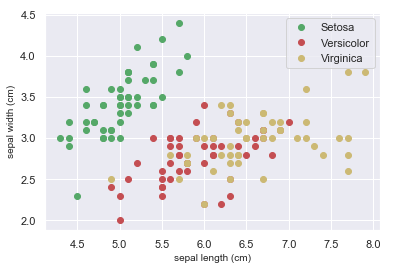

In [4]:
# PLEASE DO NOT CHANGE THIS CELL

# PLOT DATA

plot_data(X,y)    
plt.show()

We first compute a $k$-Means model with $k=3$, fit it to all data and then plot the results.

Accuracy on all data:  51.33333333333333


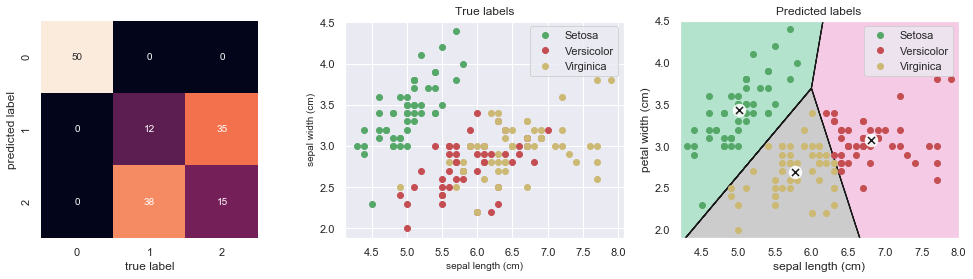

In [169]:
# PLEASE DO NOT CHANGE THIS CELL

kmeans_model1 = KMeans(n_clusters=3, random_state=42)

y_pred = kmeans_model1.fit_predict(X)
print("Accuracy on all data: ", acc(y,y_pred)*100)

plt.figure(figsize=(17, 4))
plot_kmeans_results(kmeans_model1, X, y, y_pred)

### _Question 1_

Using the $k$-Means model defined in the previous cell (with $k=3$ and `random_state=42`):

### _a) [10 marks]_

Fit the model with the train set and predict the labels from the train and test data

### _b) [10 marks]_
Compute the accuracy of the model for the train and test sets and plot the respective matrix with the predictions, the true and predicted labels of both sets (see the subplots created in the previous cell)

Accuracy on train data:  25.833333333333336


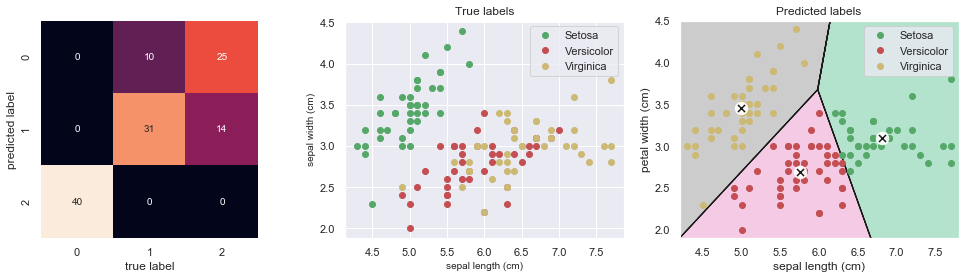

Accuracy on test data:  23.333333333333332


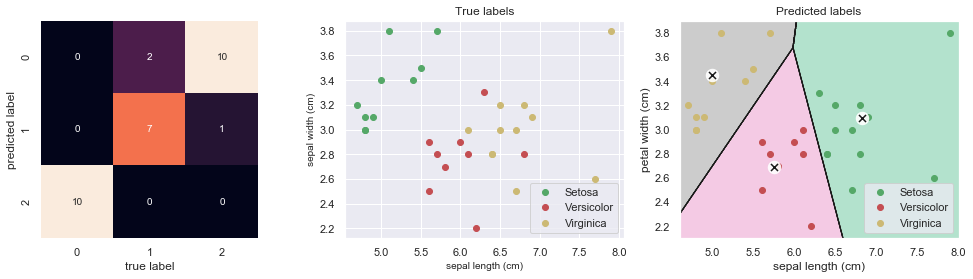

In [172]:
#######################################################
# TO_DO
# [your code here]

# apply to train data using m1
kmeans_model1.fit(X_train)
# Trainning sample prediction
predict_trn = kmeans_model1.predict(X_train)
# Test sample predction
predict_tst = kmeans_model1.predict(X_test)


# Accuracy calculation for both samples
prediction_train_acc = acc(y_train, predict_trn) * 100
prediction_test_acc = acc(y_test, predict_tst) * 100


# Plotting

print("Accuracy on train data: ", prediction_train_acc)
plt.figure(figsize=(17, 4))
plot_kmeans_results(kmeans_model1, X_train, y_train, predict_trn)
plt.show()

print("Accuracy on test data: ", prediction_test_acc)
plt.figure(figsize=(17, 4))
plot_kmeans_results(kmeans_model1, X_test, y_test, predict_tst)
plt.show()



# /TO_DO
########################################################

## $k$-Means Variability 

In the original $k$-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids. However, one major problem with this approach is that if you run $k$-Means multiple times (or with different random seeds), it can converge to very different solutions. 

In [173]:
#PLEASE DO NOT CHANGE THIS CELL

def plot_clusterer_comparison(clusterer1, clusterer2, X,y, title1=None, title2=None):
    y1 = clusterer1.fit_predict(X)
    y2 = clusterer2.fit_predict(X)

    plt.figure(figsize=(16, 4))

    plt.subplot(131)
    plt.title("True labels")
    plot_data(X,y)
    
    plt.subplot(132)
    plot_decision_boundaries(clusterer1, X,y1)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(133)
    plot_decision_boundaries(clusterer2, X,y2, )
    if title2:
        plt.title(title2, fontsize=14)
        
    print("Accuracy solution 1: ", acc(y,y1))
    print("Accuracy solution 2: ", acc(y,y2)) 

### _Question 2_

### _a) [5 marks]_ 

Create a second $k$-Means model with the same number of clusters but with a different random initialization (use `random_state=19`) and use the function defined in the above cell to compare the different models.

Accuracy solution 1:  0.5133333333333333
Accuracy solution 2:  0.08


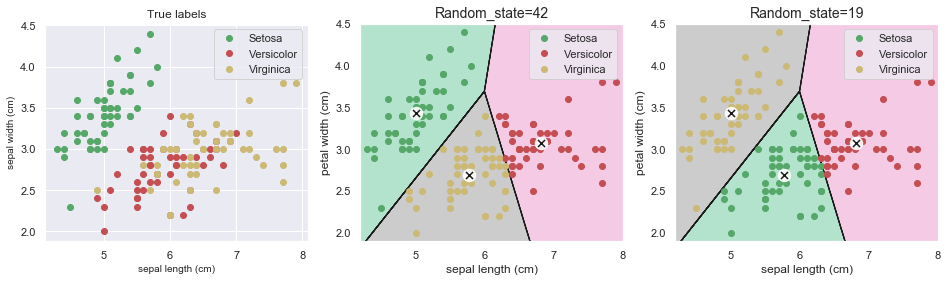

In [174]:
#######################################################
# TO_DO
# [your code here]
# define k-means m.
kmeans_model2 = KMeans(n_clusters=3, random_state=19)

# model comparison 
plot_clusterer_comparison(kmeans_model1, kmeans_model2, X, y, title1='Random_state=42', title2='Random_state=19')



# /TO_DO
##########################################################

### _b) [5 marks]_ 

How did this affect the results? Comment on the results. 

In [1]:
# [INSERT YOUR ANSWER HERE]
# The accuracies calculated for the the two solutions differ significantly.
# However, since clustering is not a classfication algorithm,
# this approach to evaluation is not applicable to it*. Clubstering should be
# evaluated with alternative methods such as adjusted_rank_score** or silhouette_score***.
# 
# The models have generated identical clusters of points. Any potential
# potential differences in grouping would be explained by the fact that
# every time we run a kmeans algorythm, we randomly select the initial position
# of the clusters' centroids, which causes overfitting. 
#
# While the resulting clusters are similar in both instances, the cluster
# labels are not the same. The reason for that is that k-means is an
# unsupervised mahcine learning technique. This means it does not know
# the true names of the clusters and asssigns them on its own.
# * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# ** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
# *** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

# Part B: Mixture of Gaussians  [60 marks]

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalising the $k$-means algorithm to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The `GaussianMixture` object implements the expectation-maximization (EM) algorithm for fitting mixture of Gaussian models. The `GaussianMixture.fit` method learns a Gaussian Mixture Model from train data and then it can assign to each test sample the Gaussian it most probably belongs to, using the `GaussianMixture.predict` method.

In [177]:
# PLEASE DO NOT CHANGE THIS CELL

colors = ['green', 'red', 'yellow']

def plot_gaussians(X, Y_, means, covariances, covariance_type, index):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, colors)):
        
        if covariance_type == 'full':
            covar = covariances[i][:2, :2]
        elif covariance_type == 'tied':
            covar = covariances[:2, :2]
        elif covariance_type == 'diag':
            covar = np.diag(covariances[i][:2])
        elif covariance_type == 'spherical':
            covar = np.eye(means.shape[1]) * covariances[i]
            
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
    plot_data(X,Y_)
    plt.xlim(4,8)
    plt.ylim(1.8,4.5)
    plt.title("Predicted labels")

Here, we will fit a Gaussian Mixture Model with 3 components and full covariance to the train data and then make predictions on both train and test data sets.

Accuracy on the train set:  54.166666666666664


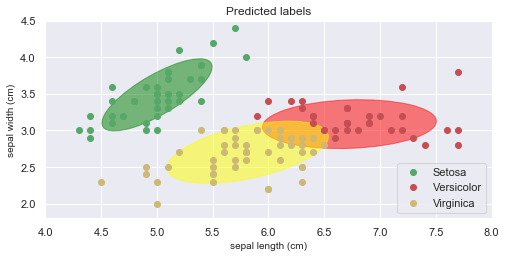

Accuracy on the test set:  53.333333333333336


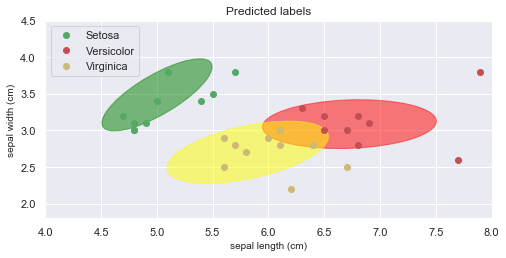

In [178]:
# PLEASE DO NOT CHANGE THIS CELL

gm_full = GaussianMixture(n_components=3,random_state=42, covariance_type='full').fit(X_train)

print("Accuracy on the train set: ", acc(y_train,gm_full.predict(X_train))*100)

plt.figure(figsize=(8, 8))
plot_gaussians(X_train, gm_full.predict(X_train), gm_full.means_, gm_full.covariances_,gm_full.covariance_type, 0)
plt.show()

print("Accuracy on the test set: ", acc(y_test,gm_full.predict(X_test))*100)

plt.figure(figsize=(8, 8))
plot_gaussians(X_test, gm_full.predict(X_test), gm_full.means_, gm_full.covariances_,gm_full.covariance_type, 1)
plt.show()

### _Question 3 [5 marks]_

Comment on the results and compare them with the $k$-Means ones.

In [2]:
# [INSERT YOUR ANSWER HERE]
# In the case of k-means we had three non-overlapping clusters.
# K-means basically creates spheres with a radius equal to the distance between the centroid and
# the most distant point and no points outside of this radius can be considered as part of the cluster. 
#
# In the case of the Gaussian mixture model above, we have elipses instead of circles and these are
# able to overlap, which reflects the ability of the model to predict the probability of a point belonging 
# to each of the clusters. As a result of this ability the Gaussian mixture model is more accurate and is 
# also sometimes called soft k-mean.

### _Question 4_

### _a) [10 marks]_

Use the Gaussian Mixture model created in the previous cell and find a way of recovering the $k$-Means results plotted in **Question 1** (**Hint:** change the covariance matrix of the model)

### _b) [10 marks]_

Display the same plots as presented in the previous cell and compute the accuracy of the model using train and test data as well.

Accuracy on the train set:  55.00000000000001


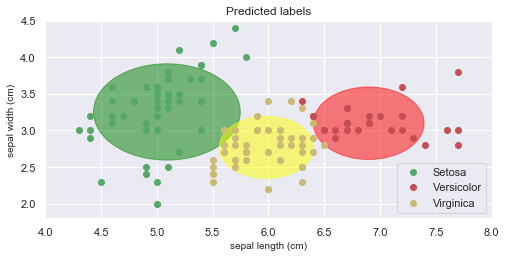

Accuracy on the test set:  46.666666666666664


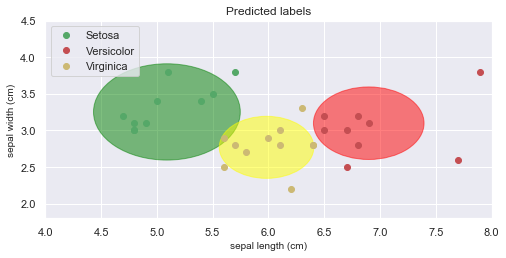

In [15]:
#######################################################
# TO_DO
# [your code here]

# Take the GM model created previously and apply set covariance to spherical to approximate k-means shape

gm_full.set_params(covariance_type='spherical')
gm_full.fit(X_train)

# prediction: train and teset datasets
predict_trn = gm_full.predict(X_train)
predict_tst = gm_full.predict(X_test)

# accuracy of predictions
prediction_train_acc = acc(y_train, predict_trn) * 100
prediction_test_acc = acc(y_test, predict_tst) * 100

# Plotting

print("Accuracy on the train set: ", prediction_train_acc)
plt.figure(figsize=(8, 8))
plot_gaussians(X_train, predict_trn, gm_full.means_, gm_full.covariances_,gm_full.covariance_type, 0)
plt.show()

print("Accuracy on the test set: ", prediction_test_acc)
plt.figure(figsize=(8, 8))
plot_gaussians(X_test, predict_tst, gm_full.means_, gm_full.covariances_,gm_full.covariance_type, 1)
plt.show()


# /TO_DO
##########################################################

### _c) [5 marks]_

How comparable are these results with the $k$-Mean results? Comment on the results.

In [3]:
# [INSERT YOUR ANSWER HERE]
# To reproduce the k-means results plotted in Question 1 using the Gaussian Mixture Model,
# I used the parameter “covariance_type=’sperical’”. This basically constrains the covariance of
# the Gaussian Mixture Model and thus, turns its ellipses into spheres similar to the once of k-means.
#
# The resulting clusters are very similar to the once created by the k-means in problem 1. Just as with the k-means,
# in this case there is almost no overlap between the resulting clusters (apart from a small section between 
# the white and the green). This is the main difference between two results: by using the spherical
# covariance parameter we approximate the clustering of the k-means but due to the probabilistic nature 
# of the Gaussian Mixture Model, these can never be fully identical.
# 
# The estimated accuracy for both the training and test data sets differ significantly from the once
# estimated in problem 1. However, as mentioned in question 2b, the accuracy function is met to measure 
# the accuracy of classification algorithms*. Therefore, it is not an appropriate measure of accuracy for 
# clustering and the diverging results do not signal a problem. Different measures should be applied
# to measure the accuracies of the two models such as adjusted_rand_score** or silhouette_score*** . 
# Finally, while in this case the labels of the clusters match, this might not always be the case as we 
# are dealing with an unsupervised learning techniques. 
#
# * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# ** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
# *** https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

## Model selection

We have been choosing the number of clusters/components for our models to be equal to the number of classes in the dataset. However, it might not represent the best model to fit the data. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(n)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $n$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalise models that have more parameters to learn (e.g., more clusters/components), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

### _Question 5_

### _a) [10 marks]_

The `GaussianMixture.bic` and `GaussianMixture.aic` methods compute the BIC and AIC values for a specific Gaussian Mixture model, respectively. Using the code below, create two variables called `bics` and `aics` for saving the respective BIC and AIC values and plot the results.

In [16]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 6)]

#######################################################
# TO_DO
# [your code here]

# set up lists bics and aics to store values:

bics = []
aics = []

# calculate the values for the Gaussian Mixture model using different numbers of components:

for gms in gms_per_k:
    bics.append(gms.bic(X))
    aics.append(gms.aic(X))


# /TO_DO
##########################################################

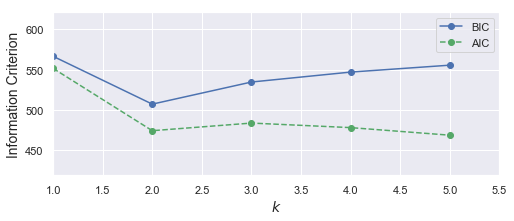

In [17]:
# PLEASE DO NOT CHANGE THIS CELL
plt.figure(figsize=(8, 3))
plt.plot(range(1, 6), bics, "bo-", label="BIC")
plt.plot(range(1, 6), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 5.5, np.min(aics) - 50, np.max(aics) + 70])
plt.legend()
plt.show()

### _b) [10 marks]_

Based on the BIC criterion, choose the best number of components and create `gm_best` variable to store a Gaussian Mixture model with full covariance structure that should best fit the data `X`.

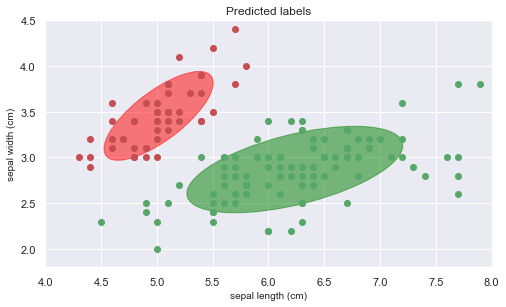

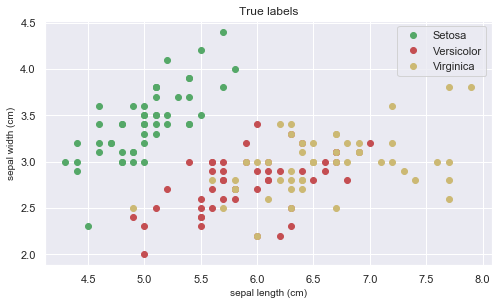

In [18]:
#######################################################
# TO_DO
# [your code here]

# BIC and AIC values show which model will be a good density estimator. The one with the lowest values is the best

gm_best= GaussianMixture(n_components=2, n_init=10, random_state=42, covariance_type='full').fit(X)

# /TO_DO
##########################################################

plt.figure(figsize=(8, 10))
plot_gaussians(X, gm_best.predict(X), gm_best.means_, gm_best.covariances_,gm_best.covariance_type, 0)
plt.legend().set_visible(False)
plt.show()

plt.figure(figsize=(8, 4.5))
plt.title("True labels")
plot_data(X,y)
plt.show()

### _c) [10 marks]_

What can you conclude from the new predicted labels (i.e. the labels predicted using the best model)? What could you do to solve the problem?

In [4]:
# [INSERT YOUR ANSWER HERE]
# We selected the model based on lowest BIC and AIC values. However, these only guarantee its performance
# as a density estimator and not necessarily as a clustering algorithm. This is illustrated by the example above, 
# which show that despite having the lowest BIC and AIC values, our model is not accurate. It predicts 2 clusters,
# where as in reality there are three. To remedy the situation, we can set the number of clusters to three (n=3).

## Part C: $k$-Means and MoG using Mice Protein Expression Data Set  [10 marks]

We will now apply the $k$-Means and Mixture of Gaussian models to the Mice Protein Expression data set.

In [179]:
from pandas import ExcelWriter
from pandas import ExcelFile

# Load the data set from the excel sheet
df = pd.read_excel('mice_data.xls', sheet_name='genes')
df.fillna(df.median(),inplace=True)

# Store the data in a DataFrame
data = df.values

y = data[:,-1].astype('int')
X = data[:,1:-5]
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### _Question 6_

### _a) [5 marks]_

Create a new $k$-Means model (with `n_clusters=8` and `random_state=42`) and Mixture of Gaussians model (with `n_components=8`, `random_state=42` and `covariance_type=full`). Fit the models to the train data and predict the new labels using the test data.

Accuracy on the test set for k-means:  12.5


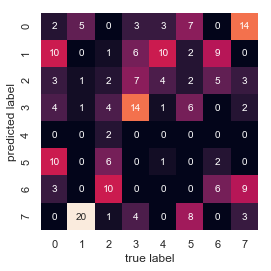

In [183]:
#######################################################
# TO_DO
# [your code here]

# generate Kmeans model and apply it to the trainning data
kmns = KMeans(n_clusters=8, random_state=42).fit(X_train)

# Test Data prediction:
y_pred_km = kmns.predict(X_test)


# /TO_DO
##########################################################

print("Accuracy on the test set for k-means: ", acc(y_test,y_pred_km) * 100)
plot_predictions(y_test, y_pred_km)

Accuracy on the test set for MoG:  18.98148148148148


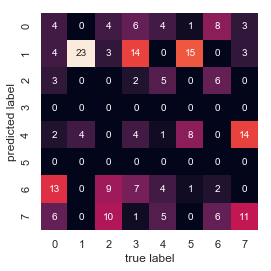

In [184]:
#######################################################
# TO_DO
# [your code here]
# generate GM model and apply it to the trainning data
gaussm = GaussianMixture(n_components=8, random_state=42, covariance_type='full').fit(X_train)

y_pred_mog = gaussm.predict(X_test)


# /TO_DO
##########################################################

print("Accuracy on the test set for MoG: ", acc(y_test,y_pred_mog) * 100)
plot_predictions(y_test, y_pred_mog)

In [5]:
# [INSERT YOUR ANSWER HERE]
# The accuracy of both the k-means and Gaussian is low. However, this cannot be taken as conclusive
# evidence that they are not appropriate clustering models. As mentioned in problem 2b, accuracy is not 
# a good performance measure for clustering algorithms. 
# Both models are able to group the data into the accurate clusters. Due to their unsupervised nature, 
# however, we are not able to measure their accuracy with respect to the true labels.
# It would be interesting to explore the opportunity to apply a classification algorithm.